In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform

In [2]:
def grid_set(data, N):
    _ , W = data.shape
    AvD1 = data.mean(0)
    X1 = np.mean(np.sum(np.power(data,2),axis=1))
    grid_trad = np.sqrt(2*(X1 - AvD1*AvD1.T))/N
    Xnorm = np.sqrt(np.sum(np.power(data,2),axis=1))
    aux = Xnorm
    for i in range(W-1):
        aux = np.insert(aux,0,Xnorm.T,axis=1)
    data = data / aux
    seq = np.argwhere(np.isnan(data))
    if tuple(seq[::]): data[tuple(seq[::])] = 1
    AvD2 = data.mean(0)
    grid_angl = np.sqrt(1-AvD2*AvD2.T)/N
    return X1, AvD1, AvD2, grid_trad, grid_angl

In [3]:
def pi_calculator(Uniquesample, mode):
    UN, W = Uniquesample.shape
    if mode == 'euclidean':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)   
        aux2 = [Uniquesample[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.power(aux2,2),axis=1)+DT1
        
    if mode == 'mahalanobis' or mode == 'cityblock' or mode == 'chebyshev' or mode == 'canberra':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)   
        uspi = np.power(cdist(Uniquesample, aux, mode),2)+DT1
        uspi = uspi[:,0]
        
    elif mode == 'minkowski':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = np.matrix(AA1)
        for i in range(UN-1): aux = np.insert(aux,0,AA1,axis=0)
        aux = np.array(aux)
        
        uspi = np.power(cdist(Uniquesample, aux, mode, p=1.5),2)+DT1
        uspi = uspi[:,0]
    
    elif mode == 'cosine':
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        aux2 = [Uniquesample1[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.sum(np.power(aux2,2),axis=1),axis=1)+DT2
        print(uspi)
        
    return uspi

In [10]:
def Globaldensity_Calculator(data, distancetype):
    Uniquesample, J, K = np.unique(data, axis=0, return_index=True, return_inverse=True)
    Frequency, _ = np.histogram(K,bins=len(J))
    uspi1 = pi_calculator(Uniquesample, distancetype)
    sum_uspi1 = sum(uspi1)
    Density_1 = uspi1 / sum_uspi1
    uspi2 = pi_calculator(Uniquesample, 'cosine')
    sum_uspi2 = sum(uspi2)
    Density_2 = uspi2 / sum_uspi2
    GD = (Density_2+Density_1) * Frequency
    index = GD.argsort()[::-1]
    GD = GD[index]
    Uniquesample = Uniquesample[index]
    Frequency = Frequency[index]
    return GD, Uniquesample, Frequency

In [11]:
def chessboard_division(Uniquesample, MMtypicality, interval1, interval2, distancetype):
    L, W = Uniquesample.shape
    if distancetype == 'euclidean':
        W = 1
    BOX = [Uniquesample[k] for k in range(W)]
    BOX_miu = [Uniquesample[k] for k in range(W)]
    BOX_S = [1]*W
    BOX_X = [sum(Uniquesample[k]**2) for k in range(W)]
    NB = W
    BOXMT = [MMtypicality[k] for k in range(W)]
    
    for i in range(W,L):
        if distancetype == 'minkowski':
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype, p=1.5)
        else:
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype)
        
        b = np.sqrt(cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric='cosine'))
        distance = np.array([a[0],b[0]]).T
        SQ = []
        for j,d in enumerate(distance):
            if d[0] < interval1 and d[1] < interval2:
                SQ.append(j)
        #SQ = np.argwhere(distance[::,0]<interval1 and (distance[::,1]<interval2))
        COUNT = len(SQ)
        if COUNT == 0:
            BOX.append(Uniquesample[i])
            NB = NB + 1
            BOX_S.append(1)
            BOX_miu.append(Uniquesample[i])
            BOX_X.append(sum(Uniquesample[i]**2))
            BOXMT.append(MMtypicality[i])
        if COUNT >= 1:
            DIS = distance[SQ[::],0]/interval1 + distance[SQ[::],1]/interval2
            b = np.argmin(DIS)
            BOX_S[SQ[b]] = BOX_S[SQ[b]] + 1
            BOX_miu[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_miu[SQ[b]] + Uniquesample[i]/BOX_S[SQ[b]]
            BOX_X[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_X[SQ[b]] + sum(Uniquesample[i]**2)/BOX_S[SQ[b]]
            BOXMT[SQ[b]] = BOXMT[SQ[b]] + MMtypicality[i]
    return BOX, BOX_miu, BOX_X, BOX_S, BOXMT, NB

In [12]:
def ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,Internval1,Internval2, distancetype):
    Centers = []
    n = 2
    ModeNumber = 0
    
    if distancetype == 'minkowski':
        distance1 = squareform(pdist(BOX_miu,metric=distancetype, p=1.5))
    else:
        distance1 = squareform(pdist(BOX_miu,metric=distancetype))        
    
    distance2 = np.sqrt(squareform(pdist(BOX_miu,metric='cosine')))
    for i in range(NB):
        seq = []
        for j,(d1,d2) in enumerate(zip(distance1[i],distance2[i])):
            if d1 < n*Internval1 and d2 < n*Internval2:
                seq.append(j)
        Chessblocak_typicality = [BOXMT[j] for j in seq]
        if max(Chessblocak_typicality) == BOXMT[i]:
            Centers.append(BOX_miu[i])
            ModeNumber = ModeNumber + 1
    return Centers, ModeNumber

In [13]:
def cloud_member_recruitment(ModelNumber,Center_samples,Uniquesample,grid_trad,grid_angl, distancetype):
    L, W = Uniquesample.shape
    Membership = np.zeros((L,ModelNumber))
    Members = np.zeros((L,ModelNumber*W))
    Count = []

    if distancetype == 'minkowski':
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype, p=1.5)/grid_trad
    else:
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype)/grid_trad

    distance2 = np.sqrt(cdist(Uniquesample, Center_samples, metric='cosine'))/grid_angl
    distance3 = distance1 + distance2
    B = distance3.argmin(1)
    for i in range(ModelNumber):
        seq = []
        for j,b in enumerate(B):
            if b == i:
                seq.append(j)
        Count.append(len(seq))
        Membership[:Count[i]:,i] = seq
        Members[:Count[i]:,W*i:W*(i+1)] = [Uniquesample[j] for j in seq]
    MemberNumber = Count
    return Members,MemberNumber,Membership,B 

In [14]:
def SelfOrganisedDirectionAwareDataPartitioning(Input, Mode):
    if Mode == 'Offline':
        data = Input['StaticData']
        L, W = data.shape
        N = Input['GridSize']
        distancetype = Input['DistanceType']
        X1, AvD1, AvD2, grid_trad, grid_angl = grid_set(data,N)
        GD, Uniquesample, Frequency = Globaldensity_Calculator(data, distancetype)
        BOX,BOX_miu,BOX_X,BOX_S,BOXMT,NB = chessboard_division(Uniquesample,GD,grid_trad,grid_angl, distancetype)
        Center,ModeNumber = ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,grid_trad,grid_angl, distancetype)
        Members,Membernumber,Membership,IDX = cloud_member_recruitment(ModeNumber,Center,data,grid_trad,grid_angl, distancetype)
        
        Boxparameter = {'BOX': BOX,
                'BOX_miu': BOX_miu,
                'BOX_S': BOX_S,
                'NB': NB,
                'XM': X1,
                'L': L,
                'AvM': AvD1,
                'AvA': AvD2,
                'GridSize': N}
        
    if Mode == 'Evolving':
        print(Mode)
    
    Output = {'C': Center,
              'IDX': IDX,
              'SystemParams': Boxparameter,
              'DistanceType': distancetype}
    return Output

##  Distance Metrics ##
### Offline Mode
##### - Magnitude
 - Euclidean: straight line between two points;
 - Mahalanobis: Multi-dimensional generalization of how many standard deviations away a point is from another;
 - Cityblock: Distance between two vectors if they could only move right angles (taxicab/manhattan);
 - Chebyshev: The greatest of difference between two vectors along any coordinate dimension;
 - Minkowski: Generalization of other distances dependent of a parameter $p$ (in this code $p=1.5$ ):
  - p = 1 $\rightarrow$ cityblock;
  - p = 2 $\rightarrow$ euclidean;
  - p = $\infty$ $\rightarrow$ chebyshev.
 - Canberra: Weighted version of Cityblock, the distinction is that the absolute difference between the variables of the two objects is divided by the sum of the absolute variable values prior to summing. It's more sensitive for points close to origin.
 
##### - Angular
 - Cossine Dissimilarity: Is one minus the cosine of the angle between two vectors

[0.58348845 1.23744358 1.10454097 1.42883377 0.93346805 0.94022023
 0.50149306 0.91099103 0.87043081 0.76968177 0.78025472 0.64392629
 0.98788774 0.96224043 0.48476654 0.76028414 0.72488867 0.61028586
 1.1309961  0.55737076 0.53448574 0.52481313 0.53097512 0.48245094
 0.47026995 0.4799557  0.45784267 0.44800425 0.39315886 0.39437537
 0.43800426 0.41295746 0.41987587 0.31547252 0.40468845 0.35475854
 0.26686647 0.37597002 0.17545158 0.14962163 0.36562216 0.35896341
 0.45257716 0.4518928  0.31522927 0.45091623 0.24665282 0.4459326
 0.15085379 0.35025124 0.36567923 0.17193073 0.16024392 0.27362776
 0.2132159  0.23597578 0.16432721 0.21168966 0.20474959 0.28929714
 0.1554774  0.36973142 1.15205811 0.36826276 0.3578093  0.2298418
 0.33443482 1.2283905  0.43364428 0.33409898 0.14981145 0.15867635
 0.19332181 0.33249159 0.29046841 0.16086654 0.5039791  0.35174434
 0.33859243 0.42913792 0.17063909 0.4259538  0.16536786 0.16394386
 0.27004179 0.18193835 0.45108682 0.64064812 0.16068649 0.191593

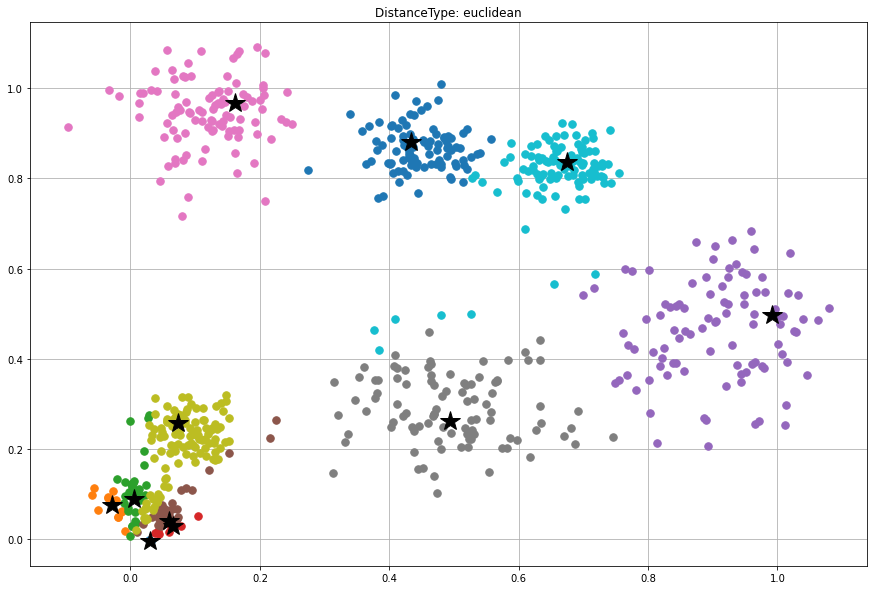

In [15]:
data = np.genfromtxt('exampledata.csv', delimiter=',')



data = np.matrix(data)
distances = ['euclidean']#, 'mahalanobis', 'cityblock', 'chebyshev', 'minkowski', 'canberra']
output = []

granularity = 6

for d in distances:
    Input = {'GridSize':granularity, 'StaticData':data, 'DistanceType': d}
    out = SelfOrganisedDirectionAwareDataPartitioning(Input,'Offline')
    output.append(out)
    
    fig = plt.figure(figsize=(15,10))
    T = np.unique(out['IDX'], axis=0)
    for t in T:
        seq = []
        for i, o in enumerate(out['IDX']):
            if o == t:
                seq.append(i)
        plt.plot(data[seq,0],data[seq,1], '.', linewidth=2, markersize=15)
    
    plt.title('DistanceType: {}'.format(d))
    plt.grid(which='both')
    plt.plot(np.array(out['C']).T[0],np.array(out['C']).T[1], 'k*', linewidth=2, markersize=20)